<a href="https://colab.research.google.com/github/kristianbagus/project/blob/main/Financial%20Data%20Challenge%20BRI%20x%20SVI%202022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Data Challenge BRI x SVI 2022

Project ini merupakan use-case dari Financial Data Challenge yang diselenggarakan oleh BRI dan Sharing Vision pada tahun 2022. Peserta ditugaskan membuat sebuah model dari 300 feature untuk menentukkan apakah customer churn/tidak. Dari data tersebut, ditemukan bahwa model mendapatkan hasil dengan AUC sebesar 0.751.

Data yang ada bersifat rahasia, sehingga hanya langkah-langkah pengerjaan yang dapat ditampilkan.

## New Section

In [ ]:
!pip install BorutaShap
!pip install catboost
!pip install optuna

# Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from BorutaShap import BorutaShap
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
from optuna.samplers import TPESampler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zipfile = zipfile.ZipFile('/content/drive/MyDrive/FDC_dataset.zip', 'r')
zipfile.extractall()

In [ ]:
# Load dataset
df = pd.read_csv('/content/FDC/findata_challenge_train.csv')

# Preview dataset
df

## Exploratory Data Analysis

Kolom numerik:

In [ ]:
df.describe().round(2)

Observasi:
  - Dataset dengan kolom tipe numerik diasumsikan semuanya berdistribusi normal (dilihat dari nilai mean dan median yang tidak berbeda jauh) 
  - Beberapa kolom memiliki nilai bilangan bulat (cth: 'x6', 'x7')
  - Beberapa kolom ('x51', 'x104', 'x118') bisa dianggap variabel boolean karena bernilai 0 dan 1

Kolom kategorik:

In [ ]:
df.select_dtypes(include=['object']).describe()

,x21,x79,x89,x108,x112
count,99874,99882,99875,99862,99858
unique,12,2,27,5,12
top,Jun,Perempuan,Kalimantan Tengah,SMP,Jul
freq,28155,50046,12449,60285,27476


  - Dalam dataset ini juga terdapat kolom kategorik seperti bulan, provinsi, dan tingkat pendidikan.

### Menghitung distribusi kelas pada variabel target

In [ ]:
# Hitung presentase distribusi kelas variabel target
freq = df['y'].value_counts() / len(df['y']) * 100
freq

0    83.008
1    16.992
Name: y, dtype: float64

Jika dilihat maka dataset ini memiliki jumlah kelas yang tidak seimbang, di mana nasabah yang churn sebesar 17% dan yang tidak sebesar 83%

### Korelasi antar variabel

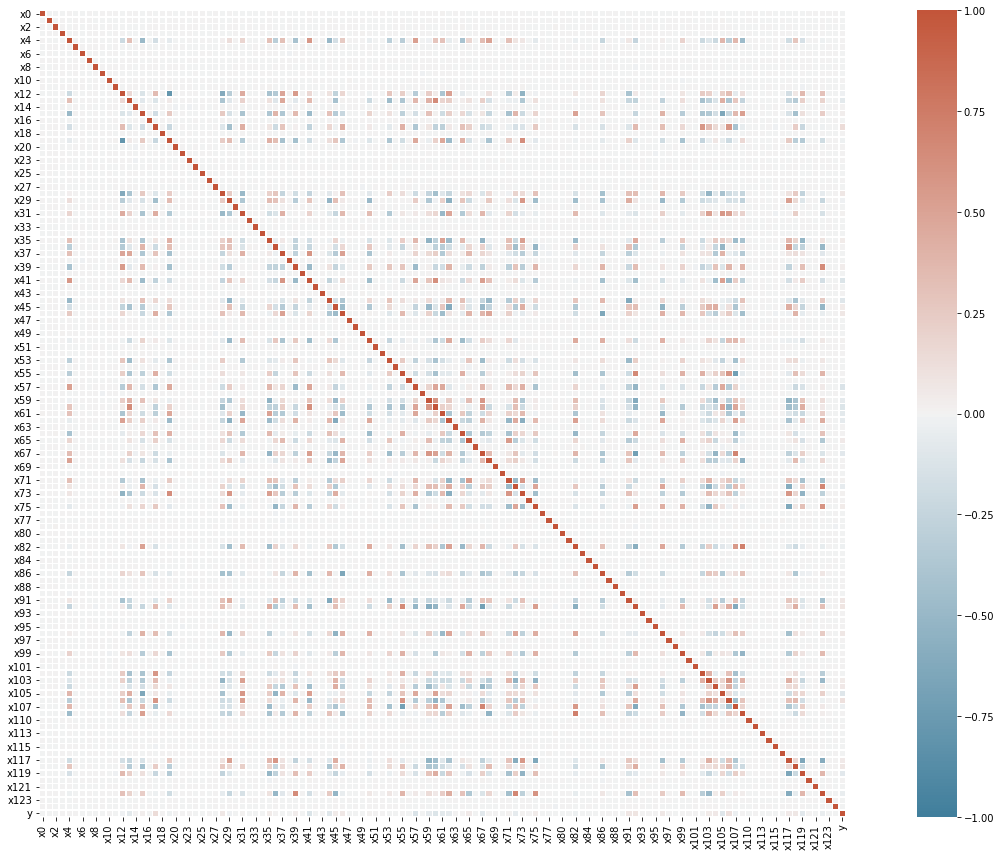

In [ ]:
# Plot korelasi
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(20,12))
sns.heatmap(corr, cmap=cmap, annot=False, center=0, vmin=-1, square=True, linewidths=.5)
plt.tight_layout()
plt.show()

Dari grafik di atas, terlihat bahwa sebagian kecil kolom memiliki korelasi satu sama lain. Namun tetap, sebagian besar dari kolom-kolom yang ada tidak berkorelasi/ berkorelasi rendah.

## Data Preprocessing

### Cek Duplicate Data

In [ ]:
df.duplicated().sum()

0

Tidak ada baris yang sama dari dataset ini.



### Train Validation Split

In [ ]:
# Gets the independent variables
X = df.drop(columns='y')
# Gets the dependent variable (the target)
y = df['y']

# Splits the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify=y, random_state=21)

Pada kasus ini data akan dibagi menjadi 85% train dan 15% test

### Handle Missing Value


Mengecek missing value:

In [ ]:
X_train.isnull().sum()

x0      103
x1      105
x2      110
x3       96
x4      114
       ... 
x120    100
x121    114
x122    104
x123    110
x124    110
Length: 125, dtype: int64

Imputasi missing value:
  - Missing value akan ditangani dengan nilai median untuk variabel numerik dan modus untuk variabel kategorik

In [ ]:
# List kolom berdasarkan tipe data
bin_categorical = ['x51', 'x79', 'x104', 'x118']
categorical = ['x21', 'x89', 'x108', 'x112']
numerical = [n for n in X_train.columns if n not in categorical + bin_categorical]

In [ ]:
# Imputasi Numerik
impute_median = SimpleImputer(strategy='median')
impute_median = impute_median.fit(X_train[numerical])
X_train[numerical] = impute_median.transform(X_train[numerical])

# Imputasi Kategorik
impute_mode = SimpleImputer(strategy='most_frequent')
impute_mode = impute_mode.fit(X_train[categorical + bin_categorical])
X_train[categorical + bin_categorical] = impute_mode.transform(X_train[categorical + bin_categorical])

Cek missing value setelah imputasi:

In [ ]:
X_train.isnull().sum().sum()

0

### Standardizing

In [ ]:
# Standardisasi nilai variabel numerik
std_scale = StandardScaler()
std_scale = std_scale.fit(X_train[numerical])
X_train[numerical] = std_scale.transform(X_train[numerical])

In [ ]:
# Cek nilai setelah distandardisasi
X_train[numerical].describe().round(2)

### Feature Engineering

Encoding variabel kategorik:

In [ ]:
# Manual Encoding
X_train['x79'] = X_train['x79'].replace({'Laki-laki':0, 'Perempuan':1})

In [ ]:
# One-hot encoding
encode = OneHotEncoder(handle_unknown='ignore')

encode.fit(X_train[categorical])
codes = encode.transform(X_train[categorical]).toarray()
feature_names = encode.get_feature_names(categorical)

X_train = pd.concat([X_train[numerical + bin_categorical].reset_index(drop=True), 
               pd.DataFrame(codes,columns=feature_names).astype(float).reset_index(drop=True)], axis=1)

In [ ]:
# Cek jumlah kolom setelah encoding
X_train.shape

(85000, 177)

### Convert Tipe Data

In [ ]:
# Convert tipe data menjadi float
X_train = X_train.astype('float')

In [ ]:
# Cek tipe data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Columns: 177 entries, x0 to x112_Sep
dtypes: float64(177)
memory usage: 114.8 MB


### Membuat Fungsi Preprocessing

Membuat fungsi preprocessing (untuk data validation dan test)

In [ ]:
# Membuat fungsi

def preprocess(df):
  # Imputation
  df[numerical] = impute_median.transform(df[numerical])
  df[categorical + bin_categorical] = impute_mode.transform(df[categorical + bin_categorical])

  # Standardize
  df[numerical] = std_scale.transform(df[numerical])

  # Manual Encoding
  df['x79'] = df['x79'].replace({'Laki-laki':0, 'Perempuan':1})

  # One-hot Encoding
  codes = encode.transform(df[categorical]).toarray()
  feature_names = encode.get_feature_names(categorical)

  df = pd.concat([df[numerical + bin_categorical].reset_index(drop=True), 
               pd.DataFrame(codes,columns=feature_names).astype(float).reset_index(drop=True)], axis=1)

  # Data Types
  df = df.astype('float')

  return df

In [ ]:
# Apply fungsi pada validation set 
X_val = preprocess(X_val)

## Feature Selection with Boruta Shap

Untuk memilih fitur mana yang sekiranya penting untuk prediksi, akan dilakukan feature selection menggunakan Boruta Shap.

In [ ]:
# Inisiasi model
estimator = CatBoostClassifier(random_state=0)
selector = BorutaShap(importance_measure = 'shap', classification = True, model=estimator)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Fit selector
selector.fit(X = X_train, y = y_train, n_trials = 100, sample = False, verbose = True)

  0%|          | 0/100 [00:00<?, ?it/s]

29 attributes confirmed important: ['x13', 'x41', 'x117', 'x37', 'x119', 'x96', 'x109', 'x72', 'x99', 'x36', 'x50', 'x64', 'x12', 'x61', 'x67', 'x15', 'x68', 'x65', 'x4', 'x105', 'x28', 'x86', 'x102', 'x53', 'x57', 'x55', 'x59', 'x44', 'x17']
141 attributes confirmed unimportant: ['x106', 'x21_Oct', 'x43', 'x21_Nov', 'x31', 'x39', 'x122', 'x89_Jawa Barat', 'x112_Nov', 'x89_Sulawesi Tenggara', 'x112_Feb', 'x66', 'x73', 'x81', 'x38', 'x116', 'x26', 'x79', 'x0', 'x91', 'x89_Kalimantan Timur', 'x108_SMA/SMK', 'x89_Kalimantan Barat', 'x89_DKI Jakarta', 'x21_Apr', 'x80', 'x111', 'x89_DI Yogyakarta', 'x27', 'x14', 'x74', 'x21_May', 'x32', 'x21_Jun', 'x114', 'x30', 'x112_Jul', 'x22', 'x45', 'x89_Sumatera Selatan', 'x77', 'x89_Bengkulu', 'x89_Kalimantan Selatan', 'x54', 'x89_Bangka Belitung', 'x58', 'x108_SD', 'x85', 'x89_Jawa Tengah', 'x70', 'x6', 'x25', 'x20', 'x112_Sep', 'x89_Maluku Utara', 'x21_Jan', 'x112_May', 'x62', 'x112_Apr', 'x107', 'x89_Maluku', 'x2', 'x78', 'x7', 'x88', 'x115', 'x90

In [ ]:
# Fix fitur tentative
selector.TentativeRoughFix()

0 tentative features are now accepted: []
7 tentative features are now rejected: ['x82' 'x98' 'x124' 'x92' 'x75' 'x118' 'x60']


Setelah dilakukan feature selection, terdapat 29 feature yang penting dan 148 feature yang bisa dibuang

In [ ]:
# List kolom yang bisa dibuang 
saved_features_to_remove = ['x106', 'x21_Oct', 'x43', 'x21_Nov', 'x31', 'x39', 'x122', 'x89_Jawa Barat', 'x112_Nov', 'x89_Sulawesi Tenggara', 'x112_Feb', 'x66', 'x73', 'x81', 'x38', 'x116', 'x26', 'x79', 'x0', 'x91', 'x89_Kalimantan Timur', 'x108_SMA/SMK', 'x89_Kalimantan Barat', 'x89_DKI Jakarta', 'x21_Apr', 'x80', 'x111', 'x89_DI Yogyakarta', 'x27', 'x14', 'x74', 'x21_May', 'x32', 'x21_Jun', 'x114', 'x30', 'x112_Jul', 'x22', 'x45', 'x89_Sumatera Selatan', 'x77', 'x89_Bengkulu', 'x89_Kalimantan Selatan', 'x54', 'x89_Bangka Belitung', 'x58', 'x108_SD', 'x85', 'x89_Jawa Tengah', 'x70', 'x6', 'x25', 'x20', 'x112_Sep', 'x89_Maluku Utara', 'x21_Jan', 'x112_May', 'x62', 'x112_Apr', 'x107', 'x89_Maluku', 'x2', 'x78', 'x7', 'x88', 'x115', 'x90', 'x47', 'x21_Aug', 'x89_Sumatera Utara', 'x108_Tidak sekolah', 'x87', 'x21_Feb', 'x108_SMP', 'x112_Jan', 'x89_Gorontalo', 'x89_NTT', 'x34', 'x112_Jun', 'x48', 'x120', 'x89_NTB', 'x21_Mar', 'x69', 'x112_Dec', 'x33', 'x97', 'x10', 'x113', 'x21_Sep', 'x89_Sumatera Barat', 'x101', 'x49', 'x83', 'x42', 'x8', 'x84', 'x46', 'x112_Mar', 'x112_Aug', 'x89_Sulawesi Tengah', 'x89_Kalimantan Tengah', 'x23', 'x1', 'x89_Sulawesi Barat', 'x3', 'x110', 'x35', 'x123', 'x71', 'x104', 'x89_Jambi', 'x19', 'x29', 'x5', 'x112_Oct', 'x56', 'x9', 'x11', 'x51', 'x21_Jul', 'x89_Jawa Timur', 'x89_Banten', 'x95', 'x89_Sulawesi Utara', 'x52', 'x108_S1/S2/S3', 'x40', 'x121', 'x89_Bali', 'x89_Kalimantan Utara', 'x63', 'x93', 'x24', 'x94', 'x103', 'x18', 'x76', 'x100', 'x16', 'x21_Dec', 'x82', 'x98', 'x124', 'x92', 'x75', 'x118', 'x60']

In [ ]:
# Eleminasi kolom yang tidak relevan
X_val_reduced = X_val.drop(columns = saved_features_to_remove)
X_train_reduced = X_train.drop(columns = saved_features_to_remove)

## Resampling with SMOTEENN

Karena jumlah distribusi class tidak seimbang, maka akan dilakukan resampling untuk mengatasi class imbalance.

In [ ]:
# Cek distribusi
print("Sebelum resampling:")
print(y_train.value_counts())

# Resampling
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=0, n_jobs=-1, sampling_strategy=0.7)
X_train_enn_reduced, y_train_enn= resample.fit_resample(X_train_reduced, y_train)

# Cek distribusi
print("\nSesudah resampling:")
print(y_train_enn.value_counts())

Sebelum resampling:
0    70557
1    14443
Name: y, dtype: int64

Sesudah resampling:
1    44520
0    44208
Name: y, dtype: int64


## Model Selection

In [ ]:
# Assign classifier model
logistic = LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
xgboost = XGBClassifier(random_state=0, n_jobs=-1)
lgbm = LGBMClassifier(random_state=0, n_jobs=-1)
catboost = CatBoostClassifier(random_state=0, verbose=False)

classifiers = {'LogReg': logistic,
               'Random Forest': rf,
               'XGBoost': xgboost,
               'LGBM': lgbm,
               'CatBoost': catboost}

In [ ]:
# Membuat grafik auc

def training(xtrain, xval, ytrain):

  fig, ax = plt.subplots(1,2,figsize=(15,6))

  for key, value in classifiers.items():
    
    # Assign Classifier 
    model = value

    # Fit and Predict
    model.fit(xtrain, ytrain)
    y_predict = model.predict(xval)
    y_train_predict = model.predict(xtrain)

    # calculate model roc curve
    fpr, tpr, thresholds = roc_curve(y_val, y_predict)
    nilai_roc = auc(fpr, tpr).round(3)
    label = str(key) + " : " + str(nilai_roc)

    # plot roc curve
    ax[0].plot(fpr, tpr, marker=',', label=label)
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC AUC')
    ax[0].legend()

    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_predict)
    pr_auc_score = auc(recall, precision).round(3)
    label = str(key) + " : " + str(pr_auc_score)

    # plot precision-recall curve
    ax[1].plot(recall, precision, marker=',', label=label)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR AUC')
    ax[1].legend()

  plt.show()

In [ ]:
training(X_train_enn_reduced, X_val_reduced, y_train_enn)

Pemilihan model:
  - Dari beberapa model yang dicoba, model CatBoost akan dipilih karena memiliki roc auc dan pr auc yang paling baik.

## Hyperparamater Tuning with Optuna

In [ ]:
# Membuat pool validation set
val_pool = Pool(X_val_reduced, y_val)

In [ ]:
# Membuat fungsi objective optuna

def objective(trial):

    param = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e0),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 30),
        "random_strength": trial.suggest_int("random_strength", 1, 100),
        "depth": trial.suggest_int("depth", 1, 10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param, eval_metric='AUC', auto_class_weights='Balanced')

    model.fit(X_train_enn_reduced, y_train_enn, eval_set=val_pool, verbose=0, early_stopping_rounds=100)

    y_predict = model.predict(X_val_reduced)
    nilai_roc = roc_auc_score(y_val, y_predict)

    return nilai_roc

In [ ]:
# Membuat study optuna
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Melihat hasil study
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-03-10 01:51:08,515] A new study created in memory with name: no-name-15e34292-f472-4891-be0f-5b1ae4ffa812
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-03-10 01:52:16,610] Trial 0 finished with value: 0.7417146772822985 and parameters: {'learning_rate': 0.016169596314861916, 'l2_leaf_reg': 5, 'random_strength': 55, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3742981278431585}. Best is trial 0 with value: 0.7417146772822985.
[I 2022-03-10 01:52:44,627] Trial 1 finished with value: 0.7288504558898737 and parameters: {'learning_rate': 0.3657988983847234, 'l2_leaf_reg': 13, 'random_strength': 37, 'depth': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.220931553993186}. Best is trial 0 with value: 0.7417146772822985.
[I 2022-03-10 01:54:23,130] Trial 2 finished with value: 0.741601704023042 and parameters: {'learning_rate': 0.07733840761537274, 'l2_leaf_reg': 29, 'random_strength': 96, 'depth': 10, 

Number of completed trials: 100
Best trial:
	Best Score: 0.7512411540646159
	Best Params: 
    learning_rate: 0.030175042584699965
    l2_leaf_reg: 25
    random_strength: 83
    depth: 10
    bootstrap_type: Bayesian
    bagging_temperature: 2.887610941683084


In [ ]:
# Melihat hyperparameter terbaik
best_params = trial.params
print(best_params)

{'learning_rate': 0.030175042584699965, 'l2_leaf_reg': 25, 'random_strength': 83, 'depth': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.887610941683084}


In [ ]:
# Menyimpan parameter terbaik
saved_best_params = {'learning_rate': 0.030175042584699965, 'l2_leaf_reg': 25, 'random_strength': 83, 'depth': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.887610941683084}

## Evaluasi Model

In [ ]:
# Membuat model dengan parameter
model = CatBoostClassifier(eval_metric='AUC', auto_class_weights='Balanced', **saved_best_params)

In [ ]:
# Fit model
model.fit(X_train_enn_reduced, y_train_enn, eval_set=val_pool, verbose=0, early_stopping_rounds=100)

# Predict evaluation set
y_predict = model.predict(X_val_reduced)

In [ ]:
# Evaluasi roc_score
print("Nilai ROC AUC Validation: ", roc_auc_score(y_val, y_predict))

Nilai ROC AUC Validation:  0.7512411540646159


## Prediksi Test Set

In [ ]:
# Load dataset
df_test = pd.read_csv('/content/FDC/findata_challenge_test.csv')

# Preview dataset
df_test

In [ ]:
# Apply fungsi preprocess pada data test 
df_test = preprocess(df_test)

# Feature selection
df_test_reduced = df_test.drop(columns = saved_features_to_remove)

In [ ]:
# Predict test set
test_predict = model.predict(df_test_reduced)

In [ ]:
test_predict

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# Simpan ke dataframe
df_csv = pd.DataFrame({"Id": np.arange(25000), "Predicted": test_predict})
df_csv

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
24995,24995,0
24996,24996,1
24997,24997,1
24998,24998,0


In [ ]:
# Simpan ke csv
df_csv.to_csv("kristian_bagus_wibowo-submission.csv",index=False)